In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tabulate import tabulate

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score


#**Functions**

In [ ]:
# Devuelve el código que permite inicializarlos
def _get_random_features_initializer(initializer, shape,seed):
    def _get_cauchy_samples(loc, scale, shape):
        np.random.seed(seed)
        probs = np.random.uniform(low=0., high=1., size=shape)
        return loc + scale * np.tan(np.pi * (probs - 0.5))

    if isinstance(initializer,str):
        if initializer == "gaussian":
            return tf.keras.initializers.RandomNormal(stddev=1.0,seed=seed)
        elif initializer == "laplacian":
            return tf.keras.initializers.Constant(
                _get_cauchy_samples(loc=0.0, scale=1.0, shape=shape))
        else:
            raise ValueError(f'Unsupported kernel initializer {initializer}')

In [ ]:
class Conv1dRFF(tf.keras.layers.Layer):

    # Contructor
    def __init__(self, output_dim, kernel_size=3, scale=None, padding='VALID', data_format='NWC', normalization=True, function=True,
                 trainable_scale=False, trainable_W=False,
                 seed=None, kernel='gaussian',
                 **kwargs):

        super(Conv1dRFF, self).__init__(**kwargs)

        self.output_dim=output_dim                  # Output dimension
        self.kernel_size=kernel_size                # Convolutional operation size
        self.scale=scale                            # Kernel gaussian
        self.padding=padding                        #
        self.data_format=data_format                # Format of operation convolutional
        self.normalization=normalization,           #
        self.function=function                      # sine or cosine
        self.trainable_scale=trainable_scale        #
        self.trainable_W=trainable_W                #
        self.seed=seed                              # Type of kernel
        self.initializer=kernel

    # ----------------------------------------------------------------------
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'output_dim': self.output_dim,
            'kernel_size': self.kernel_size,
            'scale': self.scale,
            'padding': self.padding,
            'data_format': self.data_format,
            'normalization': self.normalization,
            'function': self.function,
            'trainable': self.trainable,
            'trainable_scale':self.trainable_scale,
            'trainable_W':self.trainable_W,
            'seed':self.seed
        })
        return config

    # ----------------------------------------------------------------------
    def build(self, input_shape):

        input_dim = input_shape[-1]
        #kernel_initializer = tf.random_normal_initializer(stddev=1.0)

        kernel_initializer = _get_random_features_initializer(self.initializer,
                                                              shape=(self.kernel_size,self.kernel_size,
                                                              input_dim,
                                                              self.output_dim),
                                                              seed=self.seed)

        # Inicializador de los valores de la operación convolucional (kernel)
        self.kernel = self.add_weight(
            name='kernel',
            shape=(self.kernel_size, input_shape[-1], self.output_dim),
            dtype=tf.float32,
            initializer=kernel_initializer,
            trainable=self.trainable_W
        )
        # Incilización de los pesos del bias
        """
          Pendiente de revisar la configuración del parametro initializer
        """
        self.bias = self.add_weight(
            name='bias',
            shape=(self.output_dim,),
            dtype=tf.float32,
            initializer=tf.random_uniform_initializer(minval=0.0, maxval=2*np.pi, seed=self.seed),
            trainable=self.trainable_W
        )
        # Inicializador de ancho de banda del kernel
        if not self.scale:
            if  self.initializer == 'gaussian':
                self.scale = np.sqrt((input_dim*self.kernel_size**2)/2.0)
                #print(self.scale)
            elif self.initializer == 'laplacian':
                self.scale = 1.0
            else:
                raise ValueError(f'Unsupported kernel initializer {self.initializer}')
        #
        self.kernel_scale = self.add_weight(
            name='kernel_scale',
            shape=(1,),
            dtype=tf.float32,
            initializer=tf.compat.v1.constant_initializer(self.scale),
            trainable=self.trainable_scale,
            constraint='NonNeg'
        )

    # ----------------------------------------------------------------------
    def call(self, inputs):

        scale = tf.math.divide(1.0, self.kernel_scale)
        kernel = tf.math.multiply(scale, self.kernel)

        inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
        inputs = tf.cast(inputs, tf.float32)

        outputs = tf.nn.conv1d(inputs, kernel, stride=1, padding=self.padding, data_format=self.data_format)
        outputs = tf.nn.bias_add(outputs, self.bias)

        if self.normalization:
            if self.function:
                outputs = tf.math.multiply(tf.math.sqrt(2/self.output_dim),tf.cos(outputs))
            else:
                outputs = tf.where(tf.equal(tf.math.mod(outputs, 2), 0), tf.math.multiply(tf.math.sqrt(2/self.output_dim), tf.cos(outputs)), tf.math.multiply(tf.math.sqrt(2/self.output_dim), tf.sin(outputs)))
        else:
            if self.function:
                outputs = tf.cos(outputs)
            else:
                outputs = tf.where(tf.equal(tf.math.mod(outputs, 2), 0), tf.cos(outputs), tf.math.sqrt(2/self.output_dim), tf.sin(outputs))

        return outputs

#**Variable**

In [ ]:
window = 15
kernel_size = 3
epochs = 200
output_dim = 1000
trials_number = 10
batch_size = 16384
num_steps = 30000

#**Dataset**

In [ ]:
# Parameters: Lorenz systems
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
dt = 0.01

# Variables Initialization
x, y, z = np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps)

# Initial conditions
x[0], y[0], z[0] = 0.0, 1.0, 20.0

for i in range(1, num_steps):
    x_dot = sigma * (y[i - 1] - x[i - 1])
    y_dot = x[i - 1] * (rho - z[i - 1]) - y[i - 1]
    z_dot = x[i - 1] * y[i - 1] - beta * z[i - 1]

    x[i] = x[i - 1] + x_dot * dt
    y[i] = y[i - 1] + y_dot * dt
    z[i] = z[i - 1] + z_dot * dt

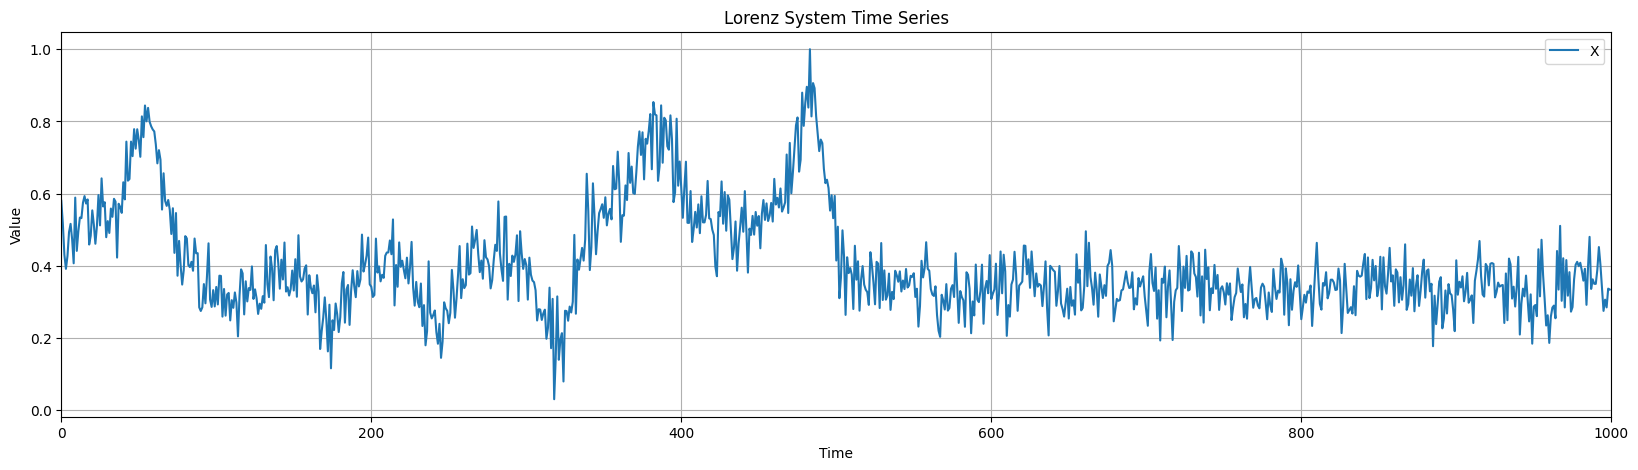

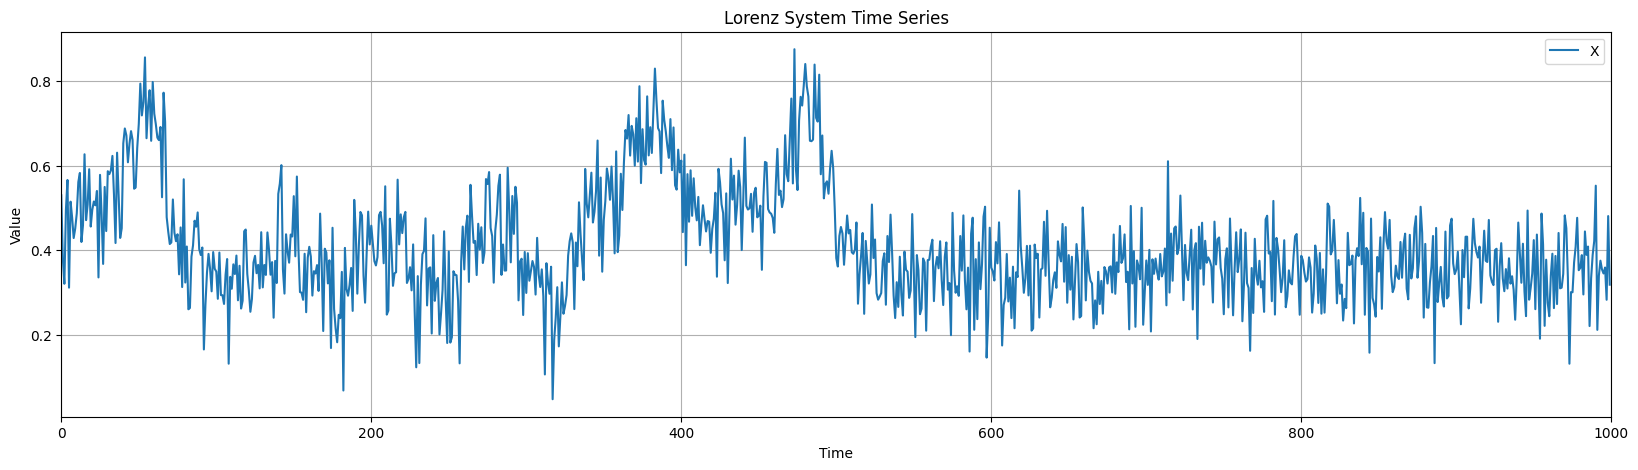

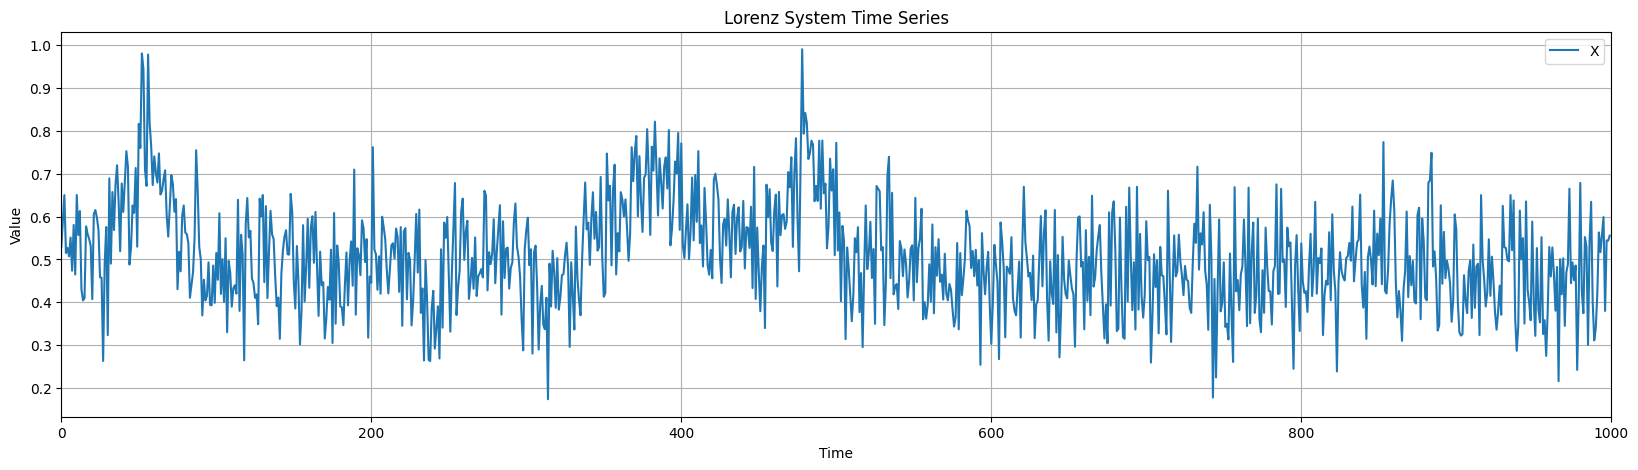

In [ ]:
# Add noise
timeSeries = []
std = [3, 5, 10]
mu = 0.1
valuesDict = {}

for value, j in zip(std, range(len(std))):
  noise = np.random.normal(mu,value,size = x.shape)
  timeserie = x + noise

  # Normalization
  timeserieNormalized = (timeserie-min(timeserie))/(max(timeserie)-min(timeserie))
  timeSeries.append(timeserieNormalized)

  plt.figure(figsize=(20, 5))
  plt.plot(timeserieNormalized[0:1000], label='X')
  plt.title('Lorenz System Time Series')
  plt.xlabel('Time'); plt.ylabel('Value')
  plt.xlim(0,1000)
  plt.legend()
  plt.grid(True)
  plt.show()

  X = np.zeros([len(timeserieNormalized)-window, window])
  for i in range(len(timeserieNormalized)-window):
    X[i,:] = timeserieNormalized[i:i+window].T

  # Output
  y = timeserieNormalized[window:]

  X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2, random_state=42)

  #print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

  valuesDict["Serie {}".format(str(j+1))] = {'Train': [X_train, y_train], 'Valid': [X_valid, y_valid], 'Test': [X_test, y_test]}

#**Training models**

In [ ]:
result = {}
for serie, k in zip(valuesDict.keys(), range(len(valuesDict))):

  print(" \n\t")

  # Data
  X_train, y_train = valuesDict[serie]["Train"][0], valuesDict[serie]["Train"][1]
  X_valid, y_valid = valuesDict[serie]["Valid"][0], valuesDict[serie]["Valid"][1]
  X_test, y_test   = valuesDict[serie]["Test"][0], valuesDict[serie]["Test"][1]

  # trials number, metrics number, models number
  matriz = np.zeros((trials_number, 4, 5))
  for trial in range(trials_number):
    print("{serie} - {trial}".format(serie=serie, trial=trial+1))

    # Convolutional 1-D ------------------------------------------------------------------
    input = tf.keras.layers.Input(shape=(X_train.shape[1], 1), name='Input')
    tmp_1 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', name='Convolutional')(input)
    tmp_1 = tf.keras.layers.MaxPooling1D(pool_size=2,name='Max_pooling')(tmp_1)
    tmp_1 = tf.keras.layers.Flatten(name='Flatten')(tmp_1)
    tmp_1 = tf.keras.layers.Dense(64, activation='relu',name='Dense')(tmp_1)
    output = tf.keras.layers.Dense(1, activation='linear', name='Output')(tmp_1)

    model_conv1D = tf.keras.Model(inputs=input, outputs=output)
    model_conv1D.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
    history = model_conv1D.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)

    forecasting_conv1D = model_conv1D.predict(X_test)

    matriz[trial][0][0] = mean_squared_error(y_test, forecasting_conv1D, squared=False)
    matriz[trial][1][0] = mean_squared_error(y_test, forecasting_conv1D, squared=True)
    matriz[trial][2][0] = mean_absolute_error(y_test, forecasting_conv1D)
    matriz[trial][3][0] = r2_score(y_test, forecasting_conv1D)

    # RFF Convolutional 1d: W=False, scale=False -----------------------------------------
    input = tf.keras.layers.Input(shape=(X_train.shape[1],1), name='Input')
    tmp_2 = Conv1dRFF(output_dim, kernel_size=kernel_size, trainable_W=False, trainable_scale=False)(input)
    tmp_2 = tf.keras.layers.Flatten()(tmp_2)
    tmp_2 = tf.keras.layers.Dense(units=64, activation='relu',name='Dense_1')(tmp_2)
    output = tf.keras.layers.Dense(units=1, activation='linear')(tmp_2)

    model_Conv1dRFF_FF = tf.keras.Model(inputs=input, outputs=output)
    model_Conv1dRFF_FF.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
    history = model_Conv1dRFF_FF.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)

    forecasting_Conv1dRFF_FF = model_Conv1dRFF_FF.predict(X_test)

    matriz[trial][0][1] = mean_squared_error(y_test, forecasting_Conv1dRFF_FF, squared=False)
    matriz[trial][1][1] = mean_squared_error(y_test, forecasting_Conv1dRFF_FF, squared=True)
    matriz[trial][2][1] = mean_absolute_error(y_test, forecasting_Conv1dRFF_FF)
    matriz[trial][3][1] = r2_score(y_test, forecasting_Conv1dRFF_FF)

    # RFF Convolutional 1d: W=False, scale=True ------------------------------------------
    input = tf.keras.layers.Input(shape=(X_train.shape[1],1), name='Input')
    tmp = Conv1dRFF(output_dim, kernel_size=kernel_size, trainable_W=False, trainable_scale=True)(input)
    tmp = tf.keras.layers.Flatten()(tmp)
    tmp = tf.keras.layers.Dense(units=64, activation='relu',name='Dense_1')(tmp)
    output = tf.keras.layers.Dense(units=1, activation='linear')(tmp)

    model_Conv1dRFF_FT = tf.keras.Model(inputs=input, outputs=output)
    model_Conv1dRFF_FT.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
    history = model_Conv1dRFF_FT.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)

    forecasting_Conv1dRFF_FT = model_Conv1dRFF_FT.predict(X_test)

    matriz[trial][0][2] = mean_squared_error(y_test, forecasting_Conv1dRFF_FT, squared=False)
    matriz[trial][1][2] = mean_squared_error(y_test, forecasting_Conv1dRFF_FT, squared=True)
    matriz[trial][2][2] = mean_absolute_error(y_test, forecasting_Conv1dRFF_FT)
    matriz[trial][3][2] = r2_score(y_test, forecasting_Conv1dRFF_FT)

    # RFF Convolutional 1d: W=True, scale=False ------------------------------------------
    input = tf.keras.layers.Input(shape=(X_train.shape[1],1), name='Input')
    tmp = Conv1dRFF(output_dim, kernel_size=kernel_size, trainable_W=True, trainable_scale=False)(input)
    tmp = tf.keras.layers.Flatten()(tmp)
    tmp = tf.keras.layers.Dense(units=64, activation='relu',name='Dense_1')(tmp)
    output = tf.keras.layers.Dense(units=1, activation='linear')(tmp)

    model_Conv1dRFF_TF = tf.keras.Model(inputs=input, outputs=output)
    model_Conv1dRFF_TF.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
    history = model_Conv1dRFF_TF.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)

    forecasting_Conv1dRFF_TF = model_Conv1dRFF_TF.predict(X_test)

    matriz[trial][0][3] = mean_squared_error(y_test, forecasting_Conv1dRFF_TF, squared=False)
    matriz[trial][1][3] = mean_squared_error(y_test, forecasting_Conv1dRFF_TF, squared=True)
    matriz[trial][2][3] = mean_absolute_error(y_test, forecasting_Conv1dRFF_TF)
    matriz[trial][3][3] = r2_score(y_test, forecasting_Conv1dRFF_TF)

    # RFF Convolutional 1d: W=True, scale=True -------------------------------------------
    input = tf.keras.layers.Input(shape=(X_train.shape[1],1), name='Input')
    tmp = Conv1dRFF(output_dim, kernel_size=kernel_size, trainable_W=True, trainable_scale=True)(input)
    tmp = tf.keras.layers.Flatten()(tmp)
    tmp = tf.keras.layers.Dense(units=64, activation='relu',name='Dense_1')(tmp)
    output = tf.keras.layers.Dense(units=1, activation='linear')(tmp)

    model_Conv1dRFF_TT = tf.keras.Model(inputs=input, outputs=output)
    model_Conv1dRFF_TT.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
    history = model_Conv1dRFF_TT.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)

    forecasting_Conv1dRFF_TT = model_Conv1dRFF_TT.predict(X_test)

    matriz[trial][0][4] = mean_squared_error(y_test, forecasting_Conv1dRFF_TT, squared=False)
    matriz[trial][1][4] = mean_squared_error(y_test, forecasting_Conv1dRFF_TT, squared=True)
    matriz[trial][2][4] = mean_absolute_error(y_test, forecasting_Conv1dRFF_TT)
    matriz[trial][3][4] = r2_score(y_test, forecasting_Conv1dRFF_TT)

    #print(matriz[trial])

  # Result to list
  result["Serie {}".format(str(k+1))] = matriz

  print(matriz)



 
	
Serie 1 - 1
188/188 [==============================] - 0s 2ms/step
Serie 1 - 2
188/188 [==============================] - 0s 2ms/step
Serie 1 - 3
188/188 [==============================] - 0s 2ms/step
Serie 1 - 4
188/188 [==============================] - 0s 2ms/step
Serie 1 - 5
188/188 [==============================] - 0s 2ms/step
Serie 1 - 6
188/188 [==============================] - 1s 2ms/step
Serie 1 - 7
188/188 [==============================] - 0s 2ms/step
Serie 1 - 8
188/188 [==============================] - 0s 2ms/step
Serie 1 - 9
188/188 [==============================] - 0s 2ms/step
Serie 1 - 10
188/188 [==============================] - 0s 2ms/step
[[[0.06645263 0.06651952 0.06574407 0.06617257 0.06627531]
  [0.00441595 0.00442485 0.00432228 0.00437881 0.00439242]
  [0.05286841 0.05261555 0.05207096 0.05235862 0.05241847]
  [0.84253657 0.8422194  0.84587659 0.843861   0.84337577]]

 [[0.06627662 0.07300114 0.06653049 0.06582682 0.06772102]
  [0.00439259 0.00532917 0.0

In [ ]:
round(r2_score(y_test, forecasting_Conv1dRFF_TT), 3)

0.313

In [ ]:
matriz[trial][3,:][0]

0.3016126299354288

In [ ]:
import pickle

picklefile = "results_proof4__.pkl"
with open(picklefile, "wb") as pkl_wb_obj:
    pickle.dump(result, pkl_wb_obj)